# TEXT MINING FOR INDONESIAN ONLINE NEWS ARTICLES ABOUT CORONA<a class='tocSkip'>
Hi! In this notebook, we will start our text mining journey by scraping a list of news articles from [tirto.id](https://www.tirto.id) and [detik.com](https://www.detik.com) about the Coronavirus using `BeautifulSoup` package. The contents will be saved to an individual .tsv (tab seperated value) files, which will be loaded again for further analysis. From there, we analyze the posting pattern for each sites and train a `Word2Vec` model using `gensim` package in order to analyze the semantic and syntactic similarity between each preprocessed words.

# Preface
## Import Packages
First thing first, we import a bunch of packages used in our analysis, mainly for scraping, text preprocessing, analyzing text, and visualization.

In [1]:
# scraping
from bs4 import BeautifulSoup
import requests
import pandas as pd

# text preprocessing
import re
import dateparser
from datetime import datetime
from itertools import repeat
from gensim.utils import simple_preprocess

# analyzing text
from gensim.models import Word2Vec
from nltk.probability import FreqDist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from adjustText import adjust_text

# other
import os
import time
import math
import multiprocessing
from tqdm import tqdm

## Set Notebook Options
* Set color of plot to match with chosen jupyterthemes style
* Suppress warning of `pandas` chaining assignment

In [2]:
from jupyterthemes import jtplot
jtplot.style()
pd.options.mode.chained_assignment = None

## Topic of Interest
Before we jump into scraping step, let's us define a `query` which will be our topic of interest. At the time of writing (24 February 2020), Coronavirus is considered as the next viral pandemic of public health - tens of thousands of people are infected which causing thousands of death. Here, we are interested to see how the Indonesian news media reports on `"corona"`.

In [3]:
query = "corona"

# Scraping
There will be two sites as our main source of analysis: [tirto.id](https://www.tirto.id) and [detik.com](https://www.detik.com). The workflow for scraping is as follow:
1. Access the link, followed by the search `query` parameter
2. Get the total page number found based on `query`
3. Get the title and URL for each article
4. Loop through each URL to scrape the content of each article and its detail (Category, Author Name, Posted Date)
5. Save to .tsv file

## Scrape from tirto.id
### Access the Link
In this step, we access [tirto.id](https://www.tirto.id) followed by the `"corona"` query and scrape the raw HTML content.

In [4]:
url_base = "https://tirto.id"
url_query = url_base + "/search?q=" + query
req = requests.get(url_query)
soup = BeautifulSoup(req.content, "html.parser")
str(soup)[:500]

'<!DOCTYPE html>\n\n<html data-n-head="lang" data-n-head-ssr="" lang="id">\n<head>\n<meta charset="utf-8" data-hid="charset" data-n-head="true"/><meta content="width=device-width, initial-scale=1" data-hid="viewport" data-n-head="true" name="viewport"/><meta content="yes" data-hid="mobile-web-app-capable" data-n-head="true" name="mobile-web-app-capable"/><meta content="corona" data-n-head="true" name="title"/><meta content="900" data-n-head="true" http-equiv="refresh"/><title data-n-head="true">Cari '

### Get Total Page Number
Before we loop through each page, we identify the `total_page` which can be found on the pagination.

In [5]:
try:
    find_pagination = soup.findAll("li", attrs = {"class": "pagination-item"})
    pagination_list = [row.a.text for row in find_pagination]
    total_page = int(pagination_list[-2])
    
    print("Total Page: {}".format(total_page))
except:
    print("Article Not Found")

Total Page: 59


### Get Title and URL
Get the title and URL for each article by looping from the first page until `total_page`. Store it as an `article` dictionary and append to `tirtoid_articles` list.

In [6]:
tirtoid_articles = []
for page_num in tqdm(range(1, total_page+1)):
    url = url_query + "&p=" + str(page_num)
    r = requests.get(url)
    s = BeautifulSoup(r.content, "html.parser")

    find_article = s.findAll("div", attrs = {"class": "news-list-fade"})
    for row in find_article:
        article = {}
        article['title'] = row.h1.text
        article['url'] = url_base + row.a['href']
        tirtoid_articles.append(article)

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:39<00:00,  1.49it/s]


In [7]:
print("Total Articles: {}".format(len(tirtoid_articles)))

Total Articles: 530


In [8]:
tirtoid_articles[:3]

[{'title': 'Update Virus Corona: Daftar 30 Negara yang Terjangkit COVID-19',
  'url': 'https://tirto.id/-update-virus-corona-daftar-30-negara-yang-terjangkit-covid-19-eA1F'},
 {'title': 'Corona Meluas di Italia, Fashion Show Giorgio Armani Digelar Online',
  'url': 'https://tirto.id/-corona-meluas-di-italia-fashion-show-giorgio-armani-digelar-online-eA1X'},
 {'title': 'Sembilan WNI Kru Kapal Diamond Princess Terinfeksi Virus Corona',
  'url': 'https://tirto.id/-sembilan-wni-kru-kapal-diamond-princess-terinfeksi-virus-corona-eA1o'}]

### Get Article Details
Get article details such as article category, author name, posted date, and content by looping through each dictionary on `tirtoid_articles` list.

In [9]:
counter = 0
for article in tqdm(tirtoid_articles):
    counter += 1

    # access the article url
    req_article = requests.get(article['url'])
    soup_article = BeautifulSoup(req_article.content, "html.parser")

    # preprocessing html
    for s in soup_article(['script', 'style']):
        s.decompose()
    for br in soup_article.find_all("br"):
        br.replace_with(" ")
    
    # get article category
    find_category = soup_article.findAll("a", attrs = {"itemprop": "item"})
    article['category'] = find_category[-1].text if len(find_category) else ""
    
    # get author name and posted date
    find_author_date = soup_article.find("span", attrs = {"class": "detail-date"})

    match = re.search(":[a-zA-Z\\.\\s]+-", find_author_date.text)
    if match is not None:
        article['author_name'] = re.sub(r'\t', '', match.group(0)[2:-2].title())

    match = re.search("\\d{1,2} [a-zA-Z]+ \\d{4}", find_author_date.text)
    if match is not None:
        article['posted_date'] = match.group(0)

    # get article content (but exclude the "Baca juga" section)
    find_baca_juga_section = soup_article.find("div", attrs = {"class": "baca-holder"})
    try:
        if find_baca_juga_section is not None:
            row.decompose()
    except:
        pass

    content = ""
    article_table = soup_article.findAll("div", attrs = {"class": "content-text-editor"})[:-1]
    article['content'] = " ".join([re.sub(r'\s+', ' ', row.text) for row in article_table])

100%|████████████████████████████████████████████████████████████████████████████████| 530/530 [12:33<00:00,  1.42s/it]


### Save to .tsv File
Finally, convert the list of dictionaries into `DataFrame` and save it into a .tsv file for further analysis.

In [10]:
tirtoid_df = pd.DataFrame(tirtoid_articles)
tirtoid_df.to_csv("scrape-results/tirtoid_{}.tsv".format(query), sep = "\t", index = False)

## Scrape from detik.com
### Access the Link
In this step, we access [detik.com](https://www.detik.com) followed by the `"corona"` query and scrape the raw HTML content.

In [11]:
url_base = "https://www.detik.com"
url_query = url_base + "/search/searchnews?query=" + query
req = requests.get(url_query)
soup = BeautifulSoup(req.content, "html.parser")
str(soup)[:500]

'<!DOCTYPE html>\n\n<html lang="id-ID">\n<head>\n<meta charset="utf-8"/>\n<meta content="IE=edge" http-equiv="X-UA-Compatible"/>\n<meta content="initial-scale = 1.0, user-scalable = no, width=device-width, height=device-height, maximum-scale=1.0" name="viewport"/>\n<meta content="yes" name="apple-mobile-web-app-capable">\n<meta content="desktop" name="platform">\n<title>detiksearch</title>\n<!--s:dtkprv-->\n<!--e:dtkprv--><link href="https://cdn.detik.net.id/detik2/images/favicon.ico" rel="shortcut icon" ty'

### Get Total Page Number
Before we loop through each page, we calculate the `total_article` which can be found on the search result page. Each result page contains 9 articles, and detik only provides maximum up to 1111 pages.

In [12]:
try:
    find_total_article = soup.find("div", attrs = {"class": "search-result"})
    total_article_match = re.search("\\d+", find_total_article.span.text)
    total_article = int(total_article_match.group(0))
    
    total_page = int(math.ceil(total_article/9))
    total_page = min(1111, total_page) # detik only provides max. 1111 pages
    
    print("Total Page: {}".format(total_page))
except:
    print("Article Not Found")

Total Page: 504


### Get Article Details
Get the details for each article by looping from the first page until `total_page`. Store it as an `article` dictionary and append to `detikcom_articles` list. The article details include URL, title, category, and posted date.

In [13]:
detikcom_articles = []
counter = 0
for page_num in tqdm(range(1, total_page+1)):
    counter += 1
    
    url = url_query + "&page=" + str(page_num)
    r = requests.get(url)
    s = BeautifulSoup(r.content, "html.parser")

    find_article = s.findAll("article")
    for row in find_article:
        article = {}

        # get url
        article['url'] = row.a['href']

        # get title
        article['title'] = row.h2.text

        # get category
        find_category = row.find("span", attrs = {"class": "category"})
        article['category'] = find_category.text
        find_category.decompose()

        # get posted date
        article['posted_date'] = row.find("span", attrs = {"class": "date"}).text

        detikcom_articles.append(article)

100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [03:00<00:00,  2.79it/s]


In [14]:
print("Total Articles: {}".format(len(detikcom_articles)))

Total Articles: 4535


In [15]:
detikcom_articles[:3]

[{'url': 'https://health.detik.com/berita-detikhealth/d-4912250/sama-sama-virus-corona-ini-bedanya-sars-cov-2-dan-covid-19',
  'title': "Sama-sama 'Virus Corona', Ini Bedanya SARS-CoV-2 dan COVID-19",
  'category': 'detikHealth',
  'posted_date': 'Senin, 24 Feb 2020 16:50 WIB'},
 {'url': 'https://news.detik.com/berita/d-4912245/jika-dievakuasi-wni-di-diamond-princess-juga-akan-diobservasi-di-pulau-sebaru',
  'title': 'Jika Dievakuasi, WNI di Diamond Princess Juga Akan Diobservasi di Pulau Sebaru',
  'category': 'detikNews',
  'posted_date': 'Senin, 24 Feb 2020 16:46 WIB'},
 {'url': 'https://hot.detik.com/art/d-4912235/koreografer-jerman-kolaborasi-bareng-seniman-indonesia-dari-5-kota',
  'title': 'Koreografer Jerman Kolaborasi Bareng Seniman Indonesia dari 5 Kota',
  'category': 'detikHot',
  'posted_date': 'Senin, 24 Feb 2020 16:41 WIB'}]

### Get Article Contents
Get articles contents and author name by looping through each dictionary on `detikcom_articles` list.

In [16]:
counter = 0
for article in tqdm(detikcom_articles):
    counter += 1

    # access the article url
    try:
        req_article = requests.get(article['url'] + "?single=1")
    except:
        continue

    soup_article = BeautifulSoup(req_article.content, "html.parser")

    # preprocessing html
    for s in soup_article(['script', 'style']):
        s.decompose()
    for br in soup_article.find_all("br"):
        br.replace_with(" ")
        
    # get author name
    match = re.search("[a-zA-Z\\.\\s]+-", find_author_date.text)
    if match is not None:
        article['author_name'] = match.group(0)[:-2].title()

    # get article content
    content = ""
    find_div = soup_article.find("div", attrs = {"class": "detail__body-text"})
    if find_div is None:
        find_div = soup_article.find("div", attrs = {"class": "itp_bodycontent"})
    if find_div is None:
        find_div = soup_article.find("div", attrs = {"class": "detail_text"})

    if find_div is not None:
        article_content = find_div.findAll("p")
        if len(article_content) == 0:
            article_content = [find_div]
        article['content'] = " ".join([re.sub(r'\s+', ' ', row.text) for row in article_content])
    else:
        article['content'] = ""

100%|████████████████████████████████████████████████████████████████████████████| 4535/4535 [1:36:21<00:00,  1.27s/it]


### Save to .tsv File
Finally, convert the list of dictionaries into `DataFrame` and save it into a .tsv file for further analysis.

In [17]:
detikcom_df = pd.DataFrame(detikcom_articles)
detikcom_df.to_csv("scrape-results/detikcom_{}.tsv".format(query), sep = "\t", index = False)

# Combine Articles
In this section, we read both of the saved .tsv files from `scrape-results` folder and do some preprocessing as follows:
1. Parse the `posted_date` column into `yyyy-mm-dd` format
2. Replace NaN with empty string `''`
3. Add new column `site` to identify the source of articles

In [18]:
tirtoid_articles = pd.read_csv("scrape-results/tirtoid_{}.tsv".format(query),
                               sep = "\t",
                               parse_dates = ['posted_date'],
                               date_parser = dateparser.parse).replace(np.nan, '', regex=True)
tirtoid_articles['site'] = 'tirtoid'

tirtoid_articles.head()

,title,url,category,author_name,posted_date,content,site
0,Update Virus Corona: Daftar 30 Negara yang Ter...,https://tirto.id/-update-virus-corona-daftar-3...,Kesehatan,Dipna Videlia Putsanra,2020-02-24,Update virus corona 24 Februari: COVID-19 tela...,tirtoid
1,"Corona Meluas di Italia, Fashion Show Giorgio ...",https://tirto.id/-corona-meluas-di-italia-fash...,Sosial Budaya,Dewi Adhitya S. Koesno,2020-02-24,"Akibat wabah virus corona meluas di Italia, Gi...",tirtoid
2,Sembilan WNI Kru Kapal Diamond Princess Terinf...,https://tirto.id/-sembilan-wni-kru-kapal-diamo...,Kesehatan,Andrian Pratama Taher,2020-02-24,Kapal pesiar mewah Diamond Princess tengah dik...,tirtoid
3,Dampak Virus Corona: Samsung Tutup Sementara P...,https://tirto.id/-dampak-virus-corona-samsung-...,Teknologi,Ibnu Azis,2020-02-24,Samsung tutup sementara pabrik yang bikin Gala...,tirtoid
4,"Virus Corona 24 Februari: 2.470 Meninggal, 79....",https://tirto.id/-virus-corona-24-februari-247...,Kesehatan,Dipna Videlia Putsanra,2020-02-24,Update jumlah korban virus corona: 2.470 orang...,tirtoid


In [19]:
detikcom_articles = pd.read_csv("scrape-results/detikcom_{}.tsv".format(query), sep = "\t").replace(np.nan, '', regex=True)
detikcom_articles['posted_date'] = \
detikcom_articles['posted_date'].str.extract('(\d{2} [A-Za-z]+ \d{4})')[0].apply(dateparser.parse)
detikcom_articles['site'] = 'detikcom'

detikcom_articles.head()

,url,title,category,posted_date,author_name,content,site
0,https://health.detik.com/berita-detikhealth/d-...,"Sama-sama 'Virus Corona', Ini Bedanya SARS-CoV...",detikHealth,2020-02-24,Selfie Miftahul Jannah,"Sejak kemunculannya di Desember 2019 lalu, pen...",detikcom
1,https://news.detik.com/berita/d-4912245/jika-d...,"Jika Dievakuasi, WNI di Diamond Princess Juga ...",detikNews,2020-02-24,Selfie Miftahul Jannah,Pemerintah masih bernegosiasi dengan pihak Jep...,detikcom
2,https://hot.detik.com/art/d-4912235/koreografe...,Koreografer Jerman Kolaborasi Bareng Seniman I...,detikHot,2020-02-24,Selfie Miftahul Jannah,"Koreografer ternama Jerman, Claudia Bosse, ber...",detikcom
3,https://inet.detik.com/cyberlife/d-4912211/rus...,Rusia Dituding Sebar Teori Konspirasi AS Dalan...,detikInet,2020-02-24,Selfie Miftahul Jannah,Rusia dituding oleh pejabat Amerika Serikat ba...,detikcom
4,https://news.detik.com/detiktv/d-4912236/itali...,Italia Dikacaukan Virus Corona,detikNews,2020-02-24,Selfie Miftahul Jannah,Liga Italia dan sejumlah kegiatan yang melibat...,detikcom


Another things to do are:
1. Combine both of the `DataFrame` into one
2. Convert column `category` and `site` as categorical data type

In [20]:
combined_articles = pd.concat([tirtoid_articles, detikcom_articles], ignore_index = True)
combined_articles[['category', 'site']] = combined_articles[['category', 'site']].astype('category')
combined_articles.dtypes

title                  object
url                    object
category             category
author_name            object
posted_date    datetime64[ns]
content                object
site                 category
dtype: object

Here's the article count for each site:

In [21]:
combined_articles.groupby('site')['content'].count()

site
detikcom    4535
tirtoid      530
Name: content, dtype: int64

# Analyze Posting Pattern
Let's us analyze how tirto and detik post articles about `"corona"` from time to time.

## Data Preparation
We are only interested with the articles which are posted in 2020. So, let's subset the `combined_articles` into `articles_2020`. Turns out more than 90% of the scraped articles posted in 2020, and the remaining 10% will be ignored.

In [22]:
start_date = '2020-01-01'
current_date = datetime.now().strftime("%Y-%m-%d")
articles_2020 = combined_articles[(combined_articles['posted_date'] >= start_date) & (combined_articles['posted_date'] < current_date)]
print('Percentage of Articles before {}: ~{:.2f}%'.format(start_date, 100*(1-articles_2020.shape[0]/combined_articles.shape[0])))
articles_2020.head()

Percentage of Articles before 2020-01-01: ~10.09%


,title,url,category,author_name,posted_date,content,site
8,Dampak Virus Corona: Serie A Tunda Jadwal Tiga...,https://tirto.id/-dampak-virus-corona-serie-a-...,Olahraga,Gilang Ramadhan,2020-02-23,Wabah virus corona (covid-19) di Italia mengak...,tirtoid
19,Cristiano Ronaldo Samai Rekor Gabriel Batistut...,https://tirto.id/-cristiano-ronaldo-samai-reko...,Olahraga,Gilang Ramadhan,2020-02-23,Cristiano menjadi pemain pertama yang mencetak...,tirtoid
20,Allianz Antisipasi Virus Corona dengan Tingkat...,https://tirto.id/-allianz-antisipasi-virus-cor...,Sosial Budaya,Yandri Daniel Damaledo,2020-02-21,Allianz Indonesia melakukan sejumlah langkah a...,tirtoid
21,Pembangunan Kereta Cepat Indo-Cina Terhambat K...,https://tirto.id/-pembangunan-kereta-cepat-ind...,Ekonomi,Hendra Friana,2020-02-21,Para pekerja proyek kereta cepat Jakarta-Bandu...,tirtoid
22,Menkes Sebut Corona Bisa Buka Peluang Industri...,https://tirto.id/-menkes-sebut-corona-bisa-buk...,Sosial Budaya,Yandri Daniel Damaledo,2020-02-21,"Menkes Terawan Agus Putranto menyebutkan, viru...",tirtoid


Let's do aggregation for `articles_2020` as follow:
1. Count articles by each `site` and `posted_date`
2. Total the aggregated `articles_count` across each row
3. Set `posted_date` as index
4. Replace NaN with 0

In [23]:
# count
articles_count = articles_2020.groupby(['site', 'posted_date'])['content'].count().unstack(level=0)

# total
articles_count.columns = articles_count.columns.add_categories(['total'])
articles_count['total'] = articles_count.sum(axis = 1)

# reindex
date_2020 = pd.date_range(start = start_date, end = max(articles_count.index))
articles_count = articles_count.reindex(date_2020)

# replace
articles_count = articles_count.fillna(0)

articles_count.tail()

site,detikcom,tirtoid,total
2020-02-19,84.0,18.0,102.0
2020-02-20,74.0,19.0,93.0
2020-02-21,103.0,15.0,118.0
2020-02-22,34.0,2.0,36.0
2020-02-23,39.0,2.0,41.0


## Create Line Plot
The data is now ready to be visualized using line plot. 

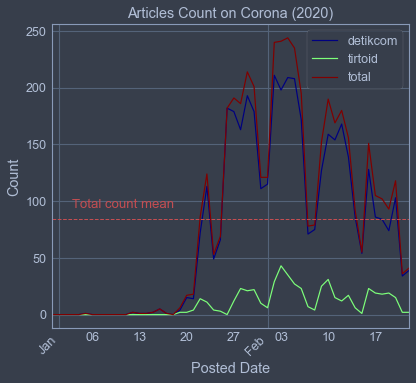

In [24]:
# line plot
ax = articles_count.plot(xlim = pd.Timestamp(start_date),
                         grid = True,
                         colormap = 'jet')

# mean line
mean_value = articles_count['total'].mean()
plt.axhline(y = mean_value,
            color = 'r',
            linestyle = '--',
            lw = 1)
plt.text(s = "Total count mean",
         x = pd.Timestamp('2020-01-04'),
         y = mean_value + 10,
         color = 'r')

# set x axis ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday = 4))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# modify legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

# add label
plt.xlabel('Posted Date')
plt.ylabel('Count')
plt.title("Articles Count on {} (2020)".format(query.title()))
plt.show()

Each tick on x-axis corresponds to Monday.

From the line plot, we can conclude that:
* The articles on `"corona"` blew up starting from the third week of January 2020 and reach its peak on the first week of February 2020.
* There is a seasonality which cycles every week. Each cycle peaks during the first half of a week and lowers during the weekend.
* [detik.com](https://www.detik.com) post `"corona"` articles about four times more frequent than [tirto.id](https://www.tirto.id) did.

# Analyze Article Contents
## Text Preprocessing

Before we jump into the analysis, the scraped text must be preprocessed by:
1. Removing stopwords, which are generally a list of most common words used in a language
2. Removing numbers and punctuation

These words are removed because do not provide any useful information to decide the context of a sentences. Here are the references for Bahasa Indonesia stopwords available on `stopwords-list` folder:
* https://github.com/har07/PySastrawi
* https://github.com/pebbie/pebahasa/blob/master/indonesian
* https://github.com/aliakbars/bilp/blob/master/stoplist
* http://web.archive.org/web/20120608052057/http://fpmipa.upi.edu/staff/yudi/stop_words_list.txt

In [25]:
stopwords_path = "stopwords-list/stopwords"
stopwords_list = []
for filename in os.listdir(stopwords_path):
    stopwords = list(open("{}/{}".format(stopwords_path, filename)).read().splitlines())
    stopwords_list.extend(stopwords)
    
stopwords_list = sorted(set(stopwords_list))
week_month_name = list(open("stopwords-list/week-month-name-id.txt").read().splitlines())
custom_stopwords = ['tirto.id', 'baca juga', 'gambas', 'video detik', 'rp']

In [26]:
def remove_words(sentence, words2remove):
    for word in words2remove:
        sentence = re.sub(r'\b' + word + r'\b', '', sentence.lower())
        sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

def text_cleaning(text):
    col_name = text.name
    
    # remove stopwords
    print("Removing stopwords of {}".format(col_name))
    time.sleep(0.5)
    text = list(map(remove_words, tqdm(text), repeat(stopwords_list + custom_stopwords + week_month_name)))

    # remove numbers and punctuations
    text = list(map(simple_preprocess, text))
    clean_text = list(map(' '.join, text))
    
    return clean_text

clean_title = text_cleaning(articles_2020['title'])
clean_content = text_cleaning(articles_2020['content'])

Removing stopwords of title


100%|██████████████████████████████████████████████████████████████████████████████| 4554/4554 [06:05<00:00, 12.45it/s]


Removing stopwords of content


100%|██████████████████████████████████████████████████████████████████████████████| 4554/4554 [21:50<00:00,  3.47it/s]


Save the preprocessed `title` and `content` to a seperate .tsv file.

In [27]:
articles_2020['clean_title'] = clean_title
articles_2020['clean_content'] = clean_content
articles_2020.to_csv("scrape-results/articles_2020_clean_{}.tsv".format(query), sep = "\t", index = False)

In [28]:
articles_2020_clean = pd.read_csv("scrape-results/articles_2020_clean_{}.tsv".format(query), sep = "\t")
articles_2020_clean.head()

,title,url,category,author_name,posted_date,content,site,clean_title,clean_content
0,Dampak Virus Corona: Serie A Tunda Jadwal Tiga...,https://tirto.id/-dampak-virus-corona-serie-a-...,Olahraga,Gilang Ramadhan,2020-02-23,Wabah virus corona (covid-19) di Italia mengak...,tirtoid,dampak virus corona serie tunda jadwal pertand...,wabah virus corona covid italia mengakibatkan ...
1,Cristiano Ronaldo Samai Rekor Gabriel Batistut...,https://tirto.id/-cristiano-ronaldo-samai-reko...,Olahraga,Gilang Ramadhan,2020-02-23,Cristiano menjadi pemain pertama yang mencetak...,tirtoid,cristiano ronaldo samai rekor gabriel batistut...,cristiano pemain mencetak rekor gol beruntun k...
2,Allianz Antisipasi Virus Corona dengan Tingkat...,https://tirto.id/-allianz-antisipasi-virus-cor...,Sosial Budaya,Yandri Daniel Damaledo,2020-02-21,Allianz Indonesia melakukan sejumlah langkah a...,tirtoid,allianz antisipasi virus corona tingkatkan keb...,allianz indonesia langkah antisipasi virus cor...
3,Pembangunan Kereta Cepat Indo-Cina Terhambat K...,https://tirto.id/-pembangunan-kereta-cepat-ind...,Ekonomi,Hendra Friana,2020-02-21,Para pekerja proyek kereta cepat Jakarta-Bandu...,tirtoid,pembangunan kereta cepat indo cina terhambat c...,pekerja proyek kereta cepat jakarta bandung ci...
4,Menkes Sebut Corona Bisa Buka Peluang Industri...,https://tirto.id/-menkes-sebut-corona-bisa-buk...,Sosial Budaya,Yandri Daniel Damaledo,2020-02-21,"Menkes Terawan Agus Putranto menyebutkan, viru...",tirtoid,menkes corona buka peluang industri farmasi ne...,menkes terawan agus putranto virus corona memb...


Here are the list of preprocessed text to be analyze:

In [29]:
clean_text = list(pd.concat([articles_2020_clean['clean_title'], articles_2020_clean['clean_content']]).sort_index().dropna())
clean_text[:2]

['dampak virus corona serie tunda jadwal pertandingan',
 'wabah virus corona covid italia mengakibatkan jadwal pertandingan serie ditunda perdana menteri italia giuseppe conte memerintahkan penundaan olahraga kawasan lombardy emilia romagna veneto penundaan mencegah penyebaran virus corona covid akibatnya jadwal pertandingan serie giornata laga inter milan vs sampdoria hellas verona vs cagliari atalanta vs sassuolo ditunda konferensi pers menteri olahraga italia vincenzo spadafora melarang wilayah izin berkomunikasi perdana menteri federasi menangguhkan olahraga provinsi terdampak virus corona spadafora dikutip tuttomercatoweb mengevaluasi keamanan maksimal penduduk sipil jam spadafora diumumkan pertandingan laga serie ascoli vs cremonese pisa vs venezia jadwal serie serie ditunda walikota milan giuseppe sala resmi menunda laga inter milan vs sampdoria diumumkan inter laman resmi jadwal laga tunda diumumkan italia mengonfirmasi korban meninggal virus corona total resmi didiagnosa terja

## Word Count
We tokenize each sentences in the `clean_text` list and calculate the frequency of each word in our scraped articles. Here, we are only interested with the top 50 most frequent words.

In [30]:
top_n_words = 50

In [31]:
tokens = ' '.join(clean_text).split(' ')
fd = FreqDist(tokens)
word_freq = pd.DataFrame(list(fd.items()), columns = ["Word", "Frequency"])\
.sort_values(by = 'Frequency', ascending = False)
top_50_words = word_freq[:top_n_words]
top_50_words.head()

,Word,Frequency
1,virus,19760
2,corona,18294
80,china,10816
232,indonesia,6208
364,wuhan,5371


### Frequency Distribution
Let's us visualize the `top_50_words` using bar chart.

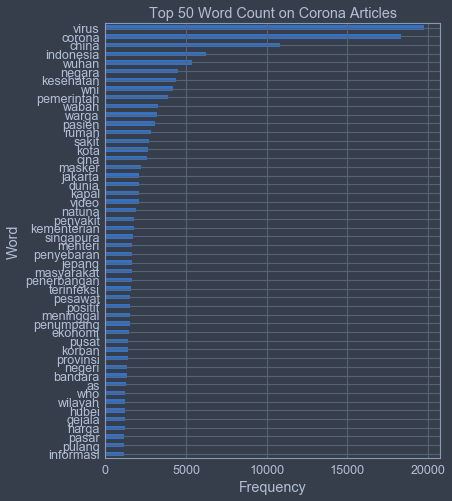

In [32]:
ax = top_50_words.plot(kind = 'barh', x = 'Word')
ax.invert_yaxis()
ax.get_legend().remove()

# add label
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title("Top {} Word Count on {} Articles".format(top_n_words, query.title()))
plt.gcf().set_size_inches(6, 8)
plt.show()

From the bar chart, it's obvious that 'virus' and 'corona' will appear as the most frequent words. But there are several words from the same category being mentioned, such as: 
* Country/city: 'china', 'indonesia', 'wuhan', 'jakarta', 'natuna', 'singapura', 'jepang', 'as', 'hubei'
* Institute: 'kesehatan', 'pemerintah', 'kementerian', 'menteri', 'who'
* Impact: 'masker', 'kapal', 'penerbangan', 'pesawat', 'ekonomi', 'bandara', 'harga', 'pasar'

### Word Cloud
To make the frequency distribution looks more visually appealing, let's make a word cloud with `china-map.png` as the mask.

In [33]:
mask = np.array(Image.open("china-map.png"))
mask[mask == 0] = 255

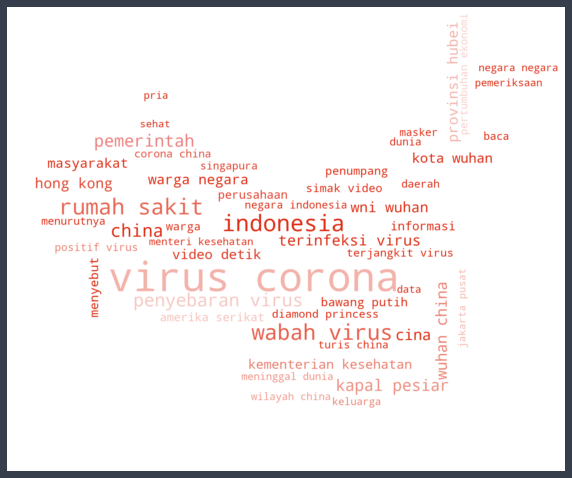

In [34]:
wordcloud_text = ' '.join(clean_text)
wordcloud = WordCloud(
    max_words = top_n_words,
    background_color = "white",
    mask = mask).generate(wordcloud_text)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.show()

# Word2Vec
So far we only focus on the frequency in which each word appears, but haven't look into the context of a word yet. Word2Vec is one technique to learn word embeddings using shallow neural network, which capable to capture semantic and syntactic similarity of words. [Reference](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

## Inspect Corpus
Let's us get some statistics of our clean corpus stored in `tokens`.

In [35]:
unique_words = set(tokens)
print("Token size: {} words".format(len(tokens)))
print("Unique token size: {} words".format(len(unique_words)))
avg_freq_token = len(tokens)/len(unique_words)
print("Average Frequency for each token: {0:.2f} times".format(avg_freq_token))

Token size: 690601 words
Unique token size: 32879 words
Average Frequency for each token: 21.00 times


## Training Model
We will be using `gensim` packages to train the model. Here are the explanation of each parameters ([Documentation](https://radimrehurek.com/gensim/models/word2vec.html)):
* `sentences` = list of tokens to be trained
* `size` = dimensionality of word vectors
* `window` = max. distance between the current and predicted word within a sentence
* `min_count` = ignore tokens with total frequency below this number
* `workers` = number of workers thread to train the model
* `iter` = number of iteration over the corpus
* `seed` = seed for the random number generator

***Uncomment the chunk below if you want to re-train the model***

In [36]:
'''
clean_token = list(map(simple_preprocess, clean_text))
model = Word2Vec(clean_token,
                 size = 500, 
                 window = 5,
                 min_count = math.ceil(avg_freq_token),
                 workers = multiprocessing.cpu_count() - 1,
                 iter = 1000,
                 seed = 123)
model.save("word2vec_{}.model".format(query))
'''

Rather than we train the same model every time we load this notebook, let's us use the pre-trained model.

In [37]:
model = Word2Vec.load("word2vec_{}.model".format(query))

## Dimensionality Reduction
The size of previous Word2Vec model is defined to be 500 dimensions. In order to visualize it in a plot, we have to reduce the dimensionality to 2 or 3 dimensions. In this section, we use PCA and t-SNE to reduce the dimension into 2 (x and y coordinates). The output of the two methods will be different, giving us two plots from different perspective.

### Principal Component Analysis (PCA)

In [38]:
vocab = list(model.wv.vocab)
pca = PCA(n_components = 2, random_state = 123)
X_pca = pca.fit_transform(model[vocab])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
word_plot_pca = pd.DataFrame(X_pca, index = vocab, columns = ['x', 'y'])
word_plot_pca.head()

,x,y
dampak,-6.705246,10.770574
virus,-14.035304,-0.235443
corona,-15.069201,-0.007217
tunda,-0.249787,-0.554645
jadwal,-0.775143,1.593133


### t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [40]:
vocab = list(model.wv.vocab)
tsne = TSNE(n_components = 2, random_state = 123)
X_tsne = tsne.fit_transform(model[vocab])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
word_plot_tsne = pd.DataFrame(X_tsne, index = vocab, columns = ['x', 'y'])
word_plot_tsne.head()

,x,y
dampak,-0.639069,-1.231255
virus,0.360826,0.692630
corona,0.329772,0.735669
tunda,-1.624454,1.872935
jadwal,-0.719885,-0.252611


## Cluster of Words
We can visualize `word_plot_pca` and `word_plot_tsne` as cluster of words in two dimensions. Two similar words will be plotted close to each other.

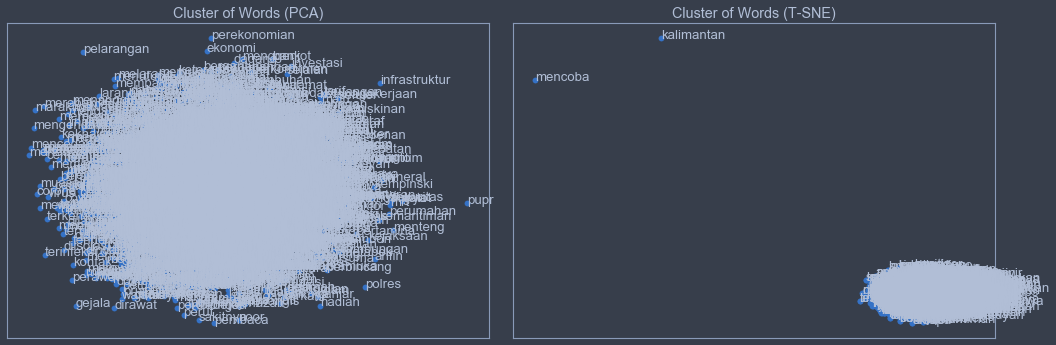

In [42]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

ax1.scatter(word_plot_pca['x'], word_plot_pca['y'])
for word, row in word_plot_pca.iterrows():
    ax1.annotate(word, (row['x'], row['y']))
    
ax2.scatter(word_plot_tsne['x'], word_plot_tsne['y'])
for word, row in word_plot_tsne.iterrows():
    ax2.annotate(word, (row['x'], row['y']))

ax1.title.set_text("Cluster of Words (PCA)")
ax2.title.set_text("Cluster of Words (T-SNE)")
plt.setp([ax1, ax2], xticks=[], yticks=[])
plt.gcf().set_size_inches(15, 5)
plt.tight_layout()
plt.show()

But unfortunately both of the plot looks very unpleasant, crowded with the tokens. Therefore, it's better for us to construct a word similarity network.

## Word Similarity Network
In this very last section, we try to build a word similarity network for a cleaner visualization. Two words will be linked together if they are similar to each other based on [cosine similarity](https://www.machinelearningplus.com/nlp/cosine-similarity/#3cosinesimilarityexample). This value can be obtained by using `model.wv.most_similar()` function. Here's the explanation of each parameter for `plot_word_similarity_network()` function:
* `word_plot` = `DataFrame` which contains the vector representation of each word
* `root` = word of interest
* `neighbour` = number of most similar words to be linked together
* `levels` = max. number of connection levels, root is considered as `level = 0`

In [43]:
def plot_word_similarity_network(word_plot, root, neighbour, levels):
    fig, ax = plt.subplots()

    colors = 'rbycgmk'
    text_sizes = lambda x: 26-3*x
    hierarchy_dict = {}
    plotted_words = [root]
    annotation_list = []
    avoid_list = []

    for level in range(levels+1):
        if level == 0:
            # only plot root word
            coord = (word_plot.loc[root]['x'], word_plot.loc[root]['y'])

            # plot point
            p = ax.scatter(coord[0], coord[1],
                       s = 100, c = colors[level],
                       label = "Root")
            avoid_list.append(p)

            # annotate
            txt = ax.text(coord[0], coord[1], root,
                          size = text_sizes(level),
                          color = colors[level])
            annotation_list.append(txt)
            similar_words = [root]
        else:
            current_hierarchy_words = []
            hierarchy_words = []
            
            for word in similar_words:
                next_similar_words = [word for word, sim in model.wv.most_similar(word)[:neighbour]]
                for sim_word in next_similar_words:
                    if sim_word not in plotted_words:
                        hierarchy_words.append("{} -> {}".format(word, sim_word))
                        current_hierarchy_words.append(sim_word)
        
                        coord = (word_plot.loc[sim_word]['x'], word_plot.loc[sim_word]['y'])
                        # plot line
                        l = ax.annotate('',
                                    xy = (word_plot.loc[word]['x'], word_plot.loc[word]['y']),
                                    xytext = coord,
                                    arrowprops = dict(arrowstyle='-', lw=1, color=colors[level-1]))

                        # plot point
                        p = ax.scatter(coord[0], coord[1],
                                   s = 100, c = colors[level],
                                   label = "Level {}".format(level))
                        avoid_list.append(p)

                        # annotate
                        txt = ax.text(coord[0], coord[1], sim_word,
                                      size = text_sizes(level),
                                      color = colors[level])
                        annotation_list.append(txt)

                        plotted_words.append(sim_word)
                similar_words = current_hierarchy_words
            hierarchy_dict[level] = hierarchy_words

    # show legend, without duplicate
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc = "upper right", bbox_to_anchor=(0, 1))

    # modify axis, title, and size
    plt.xticks([])
    plt.yticks([])
    plt.title("Word Similarity Network of '{}'\n(Neighbour: {})".format(root.title(), neighbour))
    plt.gcf().set_size_inches(15, 20)

    # repel
    adjust_text(annotation_list,
                add_objects = avoid_list,
                force_points = 0.25,
                precision = 0.1,
                arrowprops = dict(arrowstyle='<-',
                                  color='k',
                                  alpha=0.1)
                )
    plt.show()
    return hierarchy_dict

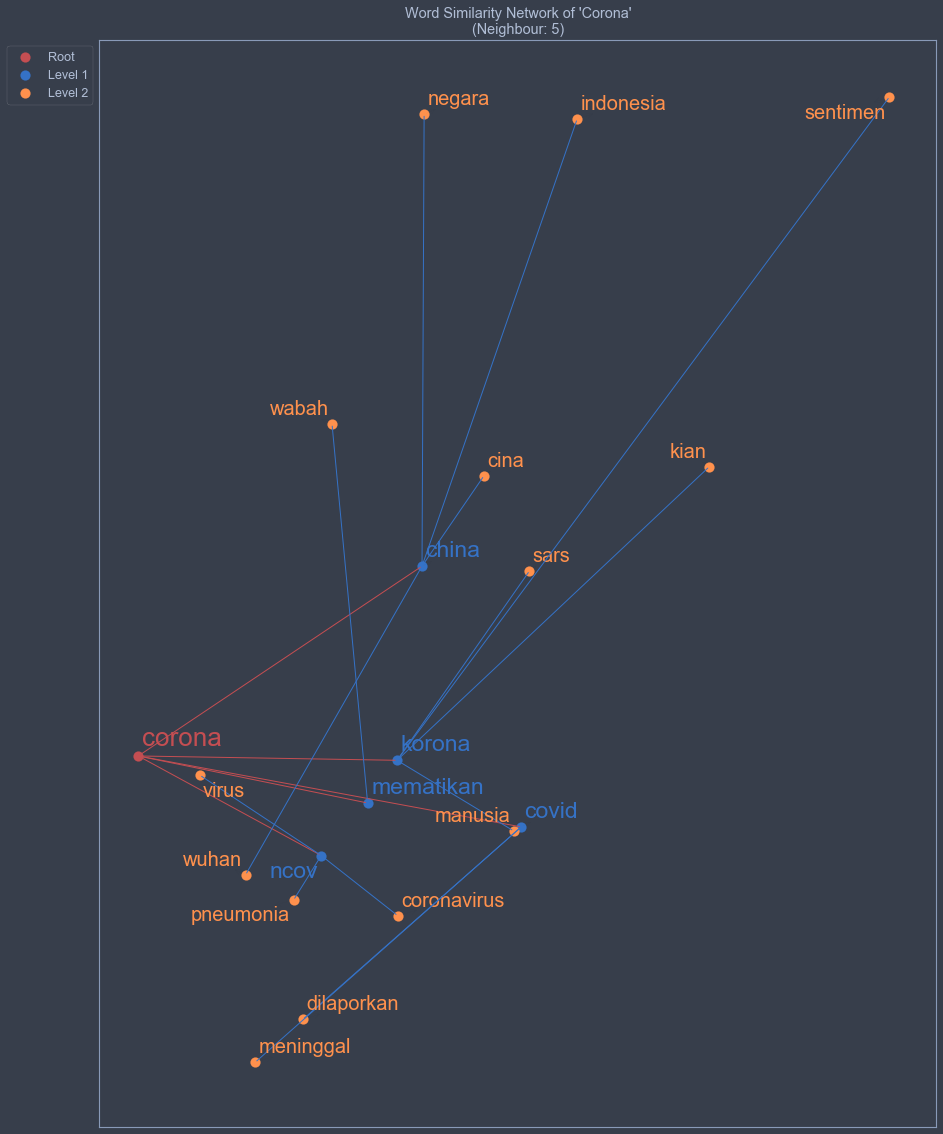

In [44]:
hierarchy_dict_pca = plot_word_similarity_network(word_plot_pca,
                                                  root = "corona",
                                                  neighbour = 5,
                                                  levels = 2)

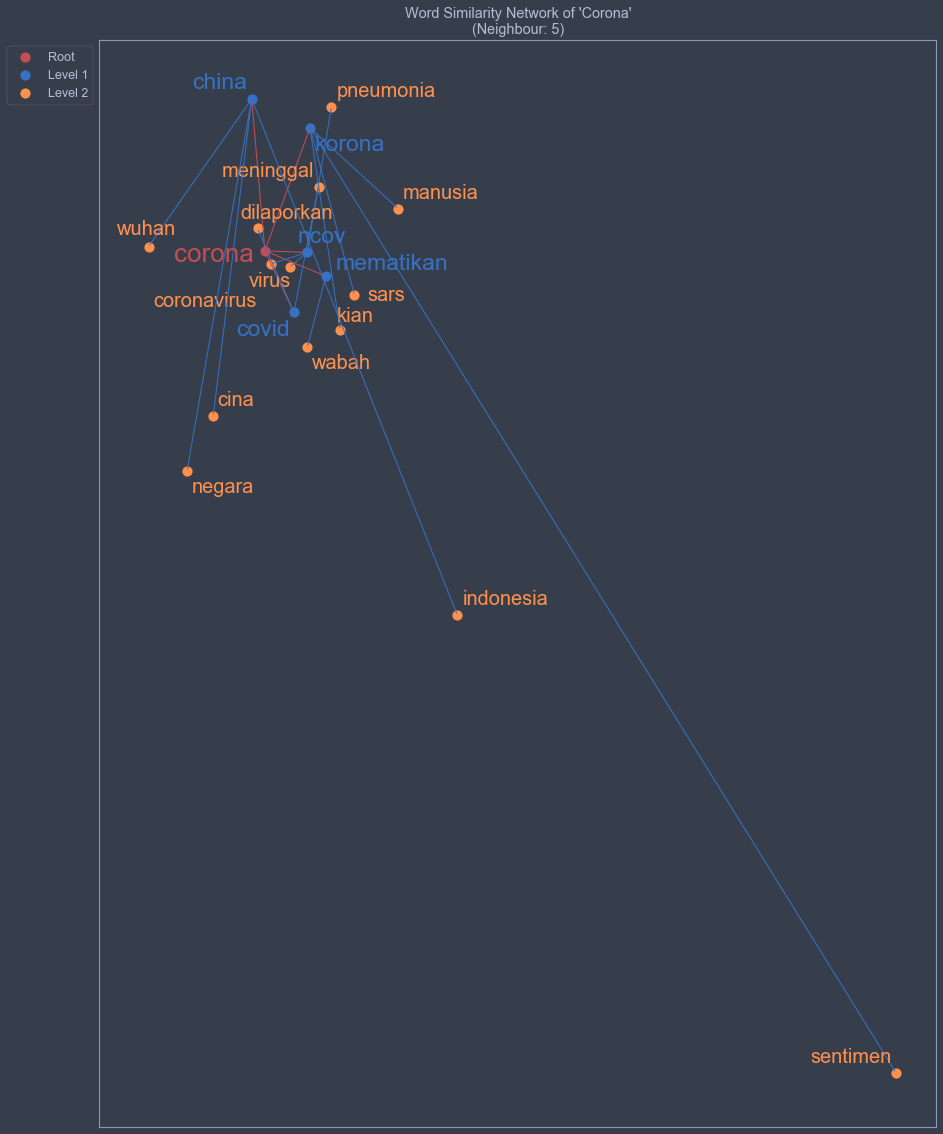

In [45]:
hierarchy_dict_tsne = plot_word_similarity_network(word_plot_tsne,
                                                   root = "corona",
                                                   neighbour = 5,
                                                   levels = 2)

In [46]:
hierarchy_dict_pca

{1: ['corona -> mematikan',
  'corona -> korona',
  'corona -> ncov',
  'corona -> covid',
  'corona -> china'],
 2: ['mematikan -> wabah',
  'korona -> sars',
  'korona -> kian',
  'korona -> manusia',
  'korona -> sentimen',
  'ncov -> virus',
  'ncov -> coronavirus',
  'ncov -> pneumonia',
  'covid -> meninggal',
  'covid -> dilaporkan',
  'china -> cina',
  'china -> negara',
  'china -> wuhan',
  'china -> indonesia']}

Both of the similarity network visualize the same connection, only with a different perspective. 

From the visualization, we can analyze the first level of similarity:
* 'ncov', 'korona', and 'covid' which basically the synonym/epidemic name for 'corona'.
* 'china' as the corona virus was first identified in Wuhan, China.
* 'mematikan' as the number of death cases keep increasing from time to time ([source](https://www.worldometers.info/coronavirus/))

Interestingly, the `Word2Vec` model can capture the fact that corona is also related to other respiratory problem such as 'sars' (Severe Acute Respiratory Syndrome) and 'pneumonia' (lung infection) just within two levels of similarity.

# Conclusion
In this notebook, we successfully scrape thousands of article from [tirto.id](https://www.tirto.id) and [detik.com](https://www.detik.com). From there, we analyze the seasonality present in the posting pattern plot and also train a `Word2Vec` model to capture the context of words. There are several things that could be improved in the future:
1. Predict the posting pattern using time series forecasting.
2. Increase corpus size for a more robust model.
3. Using skip-gram architecture for `Word2Vec` model, and compare it with CBOW (Continuous Bag-of-Words).